<a href="https://colab.research.google.com/github/rolozanod/mexico_fuel_guided_project/blob/main/Sessions/ColabSession2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

# Session 3 Building the stochastic model

1. Create the WindowGenerator object with reduced complexity
1. Create the VAE models for price and litres
1. Backtest the fitted models
1. Generate random samples

In [2]:
#!git clone https://github.com/rolozanod/mexico_fuel_guided_project.git

In [3]:
#!pip install geopandas

In [4]:
#!unzip /content/mexico_fuel_guided_project/data.zip -d /content/mexico_fuel_guided_project

In [5]:
import os
os.chdir('/content/mexico_fuel_guided_project')
os.getcwd()

'/content/mexico_fuel_guided_project'

In [6]:
!ls

README.md  capacity.csv  demand.csv   modules		   weights.h5
Sessions   data.zip	 geoinfo.csv  short_censo2020.csv


In [7]:
from modules.sessions import Session3 as sess

# Create a window generator object
This object is a variation from this __[Tensorflow Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)__

It is a deep dive into multiple approaches to predict timeseries

In [8]:
BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction
# WARNING! The model implemented in this project is designed for a window of 56+1

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

Score: 0.8760367581634618


/content/mexico_fuel_guided_project/modules/data.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily['date'] = pd.to_datetime(daily.date, format='%d/%m/%Y')
/content/mexico_fuel_guided_project/modules/data.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily['date'] = pd.to_datetime(daily.date, format='%d/%m/%Y')


Timesteps: 1520
Locations: 88


In [9]:
w

73 

Window entry: inputs

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 88 

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 88 

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 6 

Window entry: targets

Windows: 2
Tuples: 2
Batches: 16
Time: 1
Features: 88 

Windows: 2
Tuples: 2
Batches: 16
Time: 1
Features: 88 



Total window size: 58
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
Label indices: [57]
Label column name(s): MultiIndex([(                 'Aguascalientes', ...),
            (                 'Aguascalientes', ...),
            (                'Baja California', ...),
            (                'Baja California', ...),
            (            'Baja California Sur', ...),
            (                       'Campeche', ...),
            (                       'Campeche', ...),
            (                       'Campeche', ...),
            (                        'Chiapas', ...),
            (                        'Chiapas', ...),
            (                      'Chihuahua', ...),
            (                      'Chihuahua', ...),
            (                      'Chihuahua', ...),
            (               'Ciudad de Méxic

# Create the VAE models

In [125]:
FILTERS = 32 # number of filters for the convolution layers
KERNEL_SIZE = 15 # size of the convolution window (kernel)
STRIDES = 2 = # number of timesteps to skip between samples
H_UNITS = 2**8 # size of the hidden neurons for prediction
LATENT_DIMS = 2**4 # size of the embedding

# vae blocks
# price
price_ts, price_encoder, price_decoder, price_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS)

# litres
litres_ts, litres_encoder, litres_decoder, litres_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS)

In [126]:
# 80 epochs ~ 10 min
sess().train(price_vae, price_ts, litres_vae, litres_ts, window=w, MAX_EPOCHS = 80)

Epoch 250, Price loss: 9.4315%, Litres loss: 6.7662%, Price val: 9.4772%, Litres val: 5.3950%: 100%|██████████| 250/250 [33:30<00:00,  8.04s/it]  


# Run the backtest

Price loss: 6.947606086730957
Litres loss: 5.080442428588867


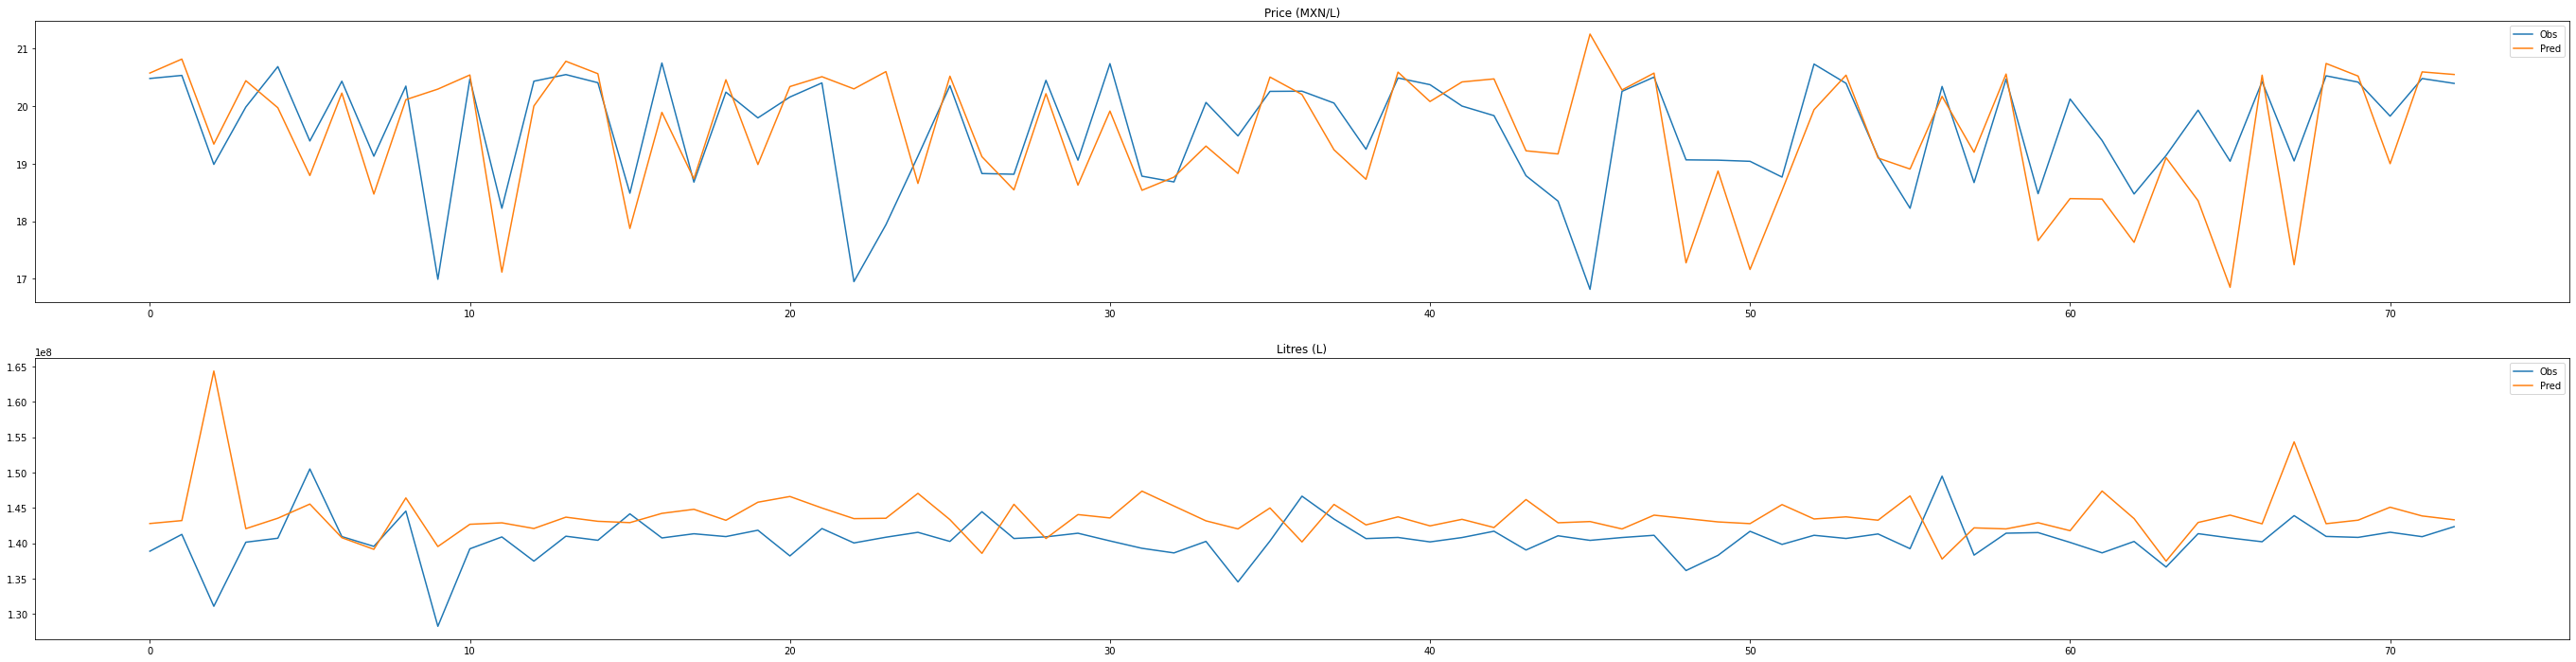

In [128]:
sess().run_backtest(price_vae, price_ts, litres_vae, litres_ts, window=w, plot=True)

In [129]:
sess().save_weights(1, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

# Create and compare random samples 

Date: 2021-12-31 00:00:00: 100%|██████████| 365/365 [00:12<00:00, 28.30it/s]


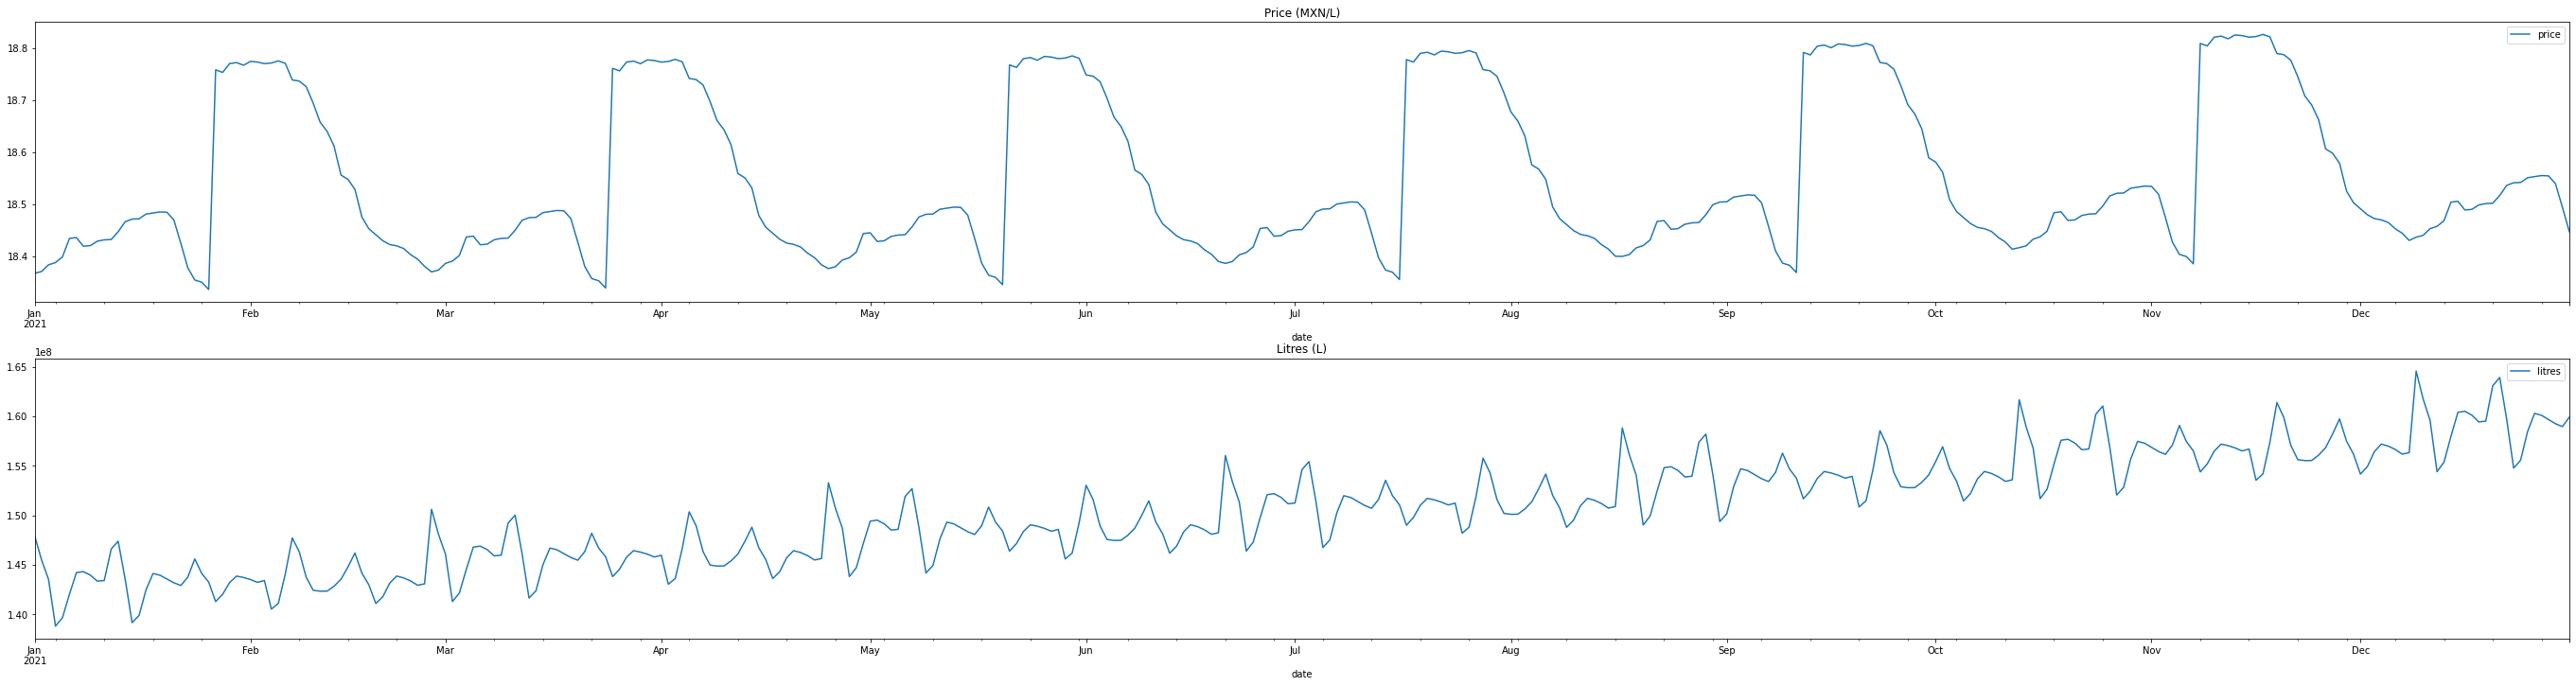

In [130]:
INIT_DATE = '2021-01-01'
FINAL_DATE = '2021-12-31'

sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

price_ts_base, litres_ts_base = sess().forecast(price_vae, price_ts, litres_vae, litres_ts, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

Date: 2021-12-31 00:00:00: 100%|██████████| 365/365 [00:13<00:00, 27.65it/s]


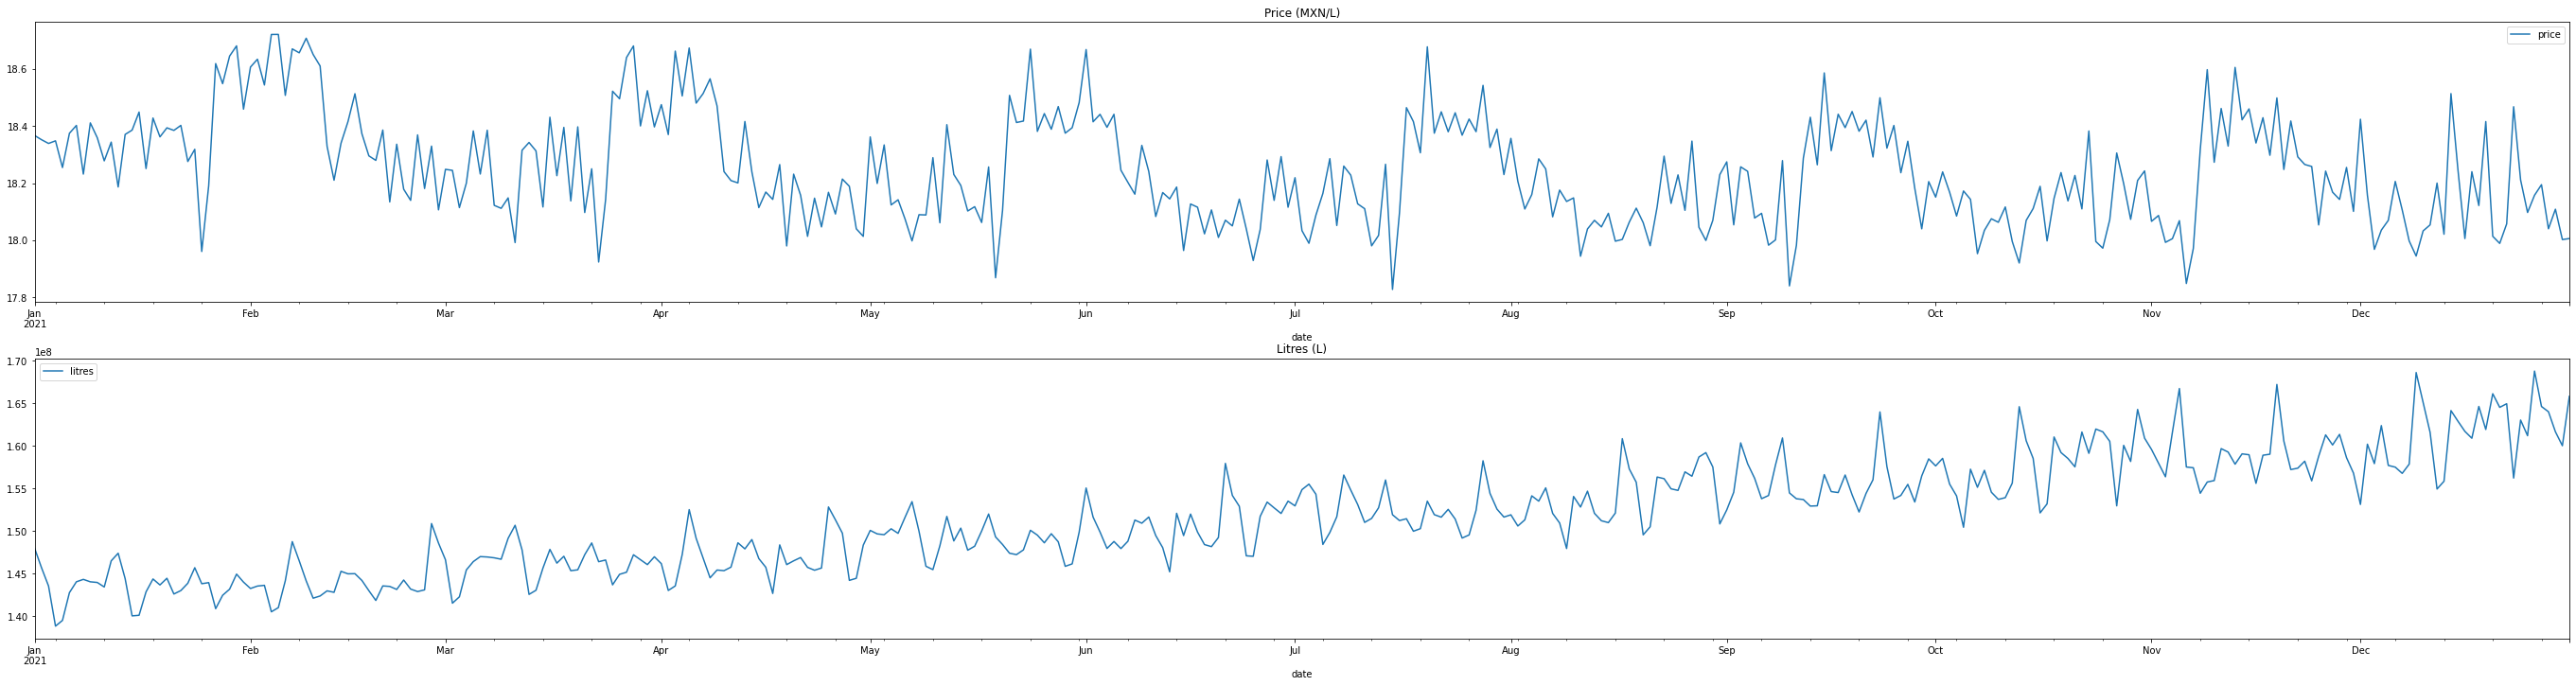

In [139]:
# vae random blocks
# price
price_ts, price_encoder, price_decoder, price_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS, random=True, amplitude=20)

# litres
litres_ts, litres_encoder, litres_decoder, litres_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS, random=True, amplitude=100)

sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

price_ts_rand, litres_ts_rand = sess().forecast(price_vae, price_ts, litres_vae, litres_ts, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

In [140]:
print(f'Price mean average percentage variation: {100*((price_ts_base.price - price_ts_rand.price).div(price_ts_base.price)).abs().mean():.2f}%')
print(f'Volume mean average percentage variation: {100*((litres_ts_base.litres - litres_ts_rand.litres).div(litres_ts_base.litres)).abs().mean():.2f}%')

Price mean average percentage variation: 10.20%
Volume mean average percentage variation: 8.17%


# All done with creating samples using VAE, see you on the next video where we will optimize multiple scenarios